# Importando


In [1]:
import matplotlib.pyplot as plt
import pandas as pd   
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def ColabOuCode(path_drive, path_local, ncolunas=None):
    '''
    Importa o DataFrame de acordo com a plataforma usada. Retorna um DataFrame.
    '''
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        df = pd.read_csv(path_drive)
    except:
        if ncolunas is None: df = pd.read_csv(path_local)
        else: df = pd.read_csv(path_local, nrows=ncolunas)
    return df

In [2]:
drive = '/content/drive/MyDrive/Colab Notebooks/TERA-desafio-3/data/dados_tratados.csv'
local = './data/dados_tratados.csv'

df = ColabOuCode(
    drive,
    local,
    ncolunas=None
)

df.shape    

(6362620, 12)

In [3]:
df.head()

,hora,type_label,nameOrig,oldbalanceOrig,origReinc,newbalanceOrig,nameDest,oldbalanceDest,destReinc,newbalanceDest,classAmount_label,isFraud
0,0,3,1231006815,12.044353,0,11.984780,1979787155,0.000000,0,0.0,2,1
1,0,3,1666544295,9.964065,0,9.872240,2044282225,0.000000,0,0.0,2,1
2,0,4,1305486145,5.198497,0,0.000000,553264065,0.000000,0,0.0,1,0
3,0,1,840083671,5.198497,0,0.000000,38997010,9.960907,0,0.0,1,0
4,0,3,2048537720,10.634749,0,10.305141,1230701703,0.000000,0,0.0,2,1


# Classificações

In [4]:
# Métricas
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Separando e balanceando os dados

In [5]:
%%time

from sklearn.model_selection import train_test_split

x_df = df.drop('isFraud',axis=1)
y_df = df[['isFraud']]

X_treino, X_teste, y_treino, y_teste = train_test_split(x_df, y_df, test_size=0.3, random_state=42)

del df, x_df, y_df


CPU times: user 1.8 s, sys: 134 ms, total: 1.93 s
Wall time: 1.97 s


In [6]:
%%time

from imblearn.combine import SMOTEENN

sennComb = SMOTEENN(
    sampling_strategy=0.2,
    random_state=42,
    n_jobs=-1
)

X_comb, y_comb = sennComb.fit_resample(X_treino, y_treino)

CPU times: user 3min 3s, sys: 3.79 s, total: 3min 7s
Wall time: 1min 23s


<AxesSubplot:xlabel='isFraud', ylabel='count'>

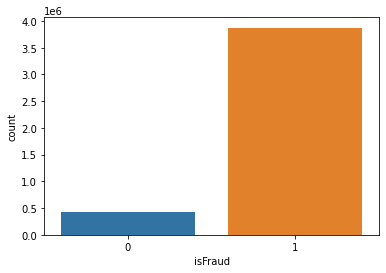

In [7]:
sns.countplot(y_comb['isFraud'])

## Decision Tree

In [8]:
%%time

from sklearn.tree import DecisionTreeClassifier

arvoreDecisao = DecisionTreeClassifier(
    max_depth=8
)
arvoreDecisao.fit(X_comb, y_comb)

y_arvPred = arvoreDecisao.predict(X_teste)

confusion_matrix(y_teste, y_arvPred)


CPU times: user 41.3 s, sys: 350 ms, total: 41.7 s
Wall time: 42.1 s


array([[   2125,     310],
       [   6262, 1900089]])

In [9]:
print(classification_report(y_teste, y_arvPred, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.25      0.87      0.39      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.63      0.93      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786



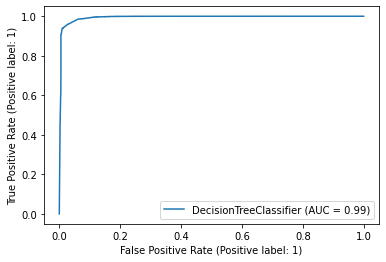

In [10]:
plot_roc_curve(arvoreDecisao, X_teste, y_teste,)
plt.show()

## Random Forest


In [11]:
%%time

from sklearn.ensemble import RandomForestClassifier

randForest = RandomForestClassifier(
    n_estimators=8,
    max_depth=13,
)

randForest.fit(X_comb, y_comb)

y_arvRandPred = randForest.predict(X_teste)

confusion_matrix(y_teste, y_arvRandPred)


CPU times: user 1min 26s, sys: 867 ms, total: 1min 27s
Wall time: 1min 27s


array([[   2071,     364],
       [   2232, 1904119]])

In [12]:
print(classification_report(y_teste, y_arvRandPred, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.48      0.85      0.61      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.74      0.92      0.81   1908786
weighted avg       1.00      1.00      1.00   1908786



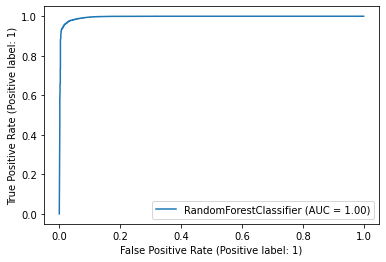

In [13]:
plot_roc_curve(randForest, X_teste, y_teste,)
plt.show()

## XGBoost Desbalanceado

In [14]:
%%time

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=13,
    max_depth=13,
    subsample=0.75,
    #gpu_id='0',
    #tree_method='gpu_hist'

)

xgb.fit(X_treino, y_treino) 
y_xgb = xgb.predict(X_teste)

confusion_matrix(y_teste, y_xgb)

[12:15:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 8min 9s, sys: 1.05 s, total: 8min 10s
Wall time: 2min 30s


array([[   1804,     631],
       [    105, 1906246]])

In [15]:
print(classification_report(y_teste, y_xgb, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.94      0.74      0.83      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.97      0.87      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



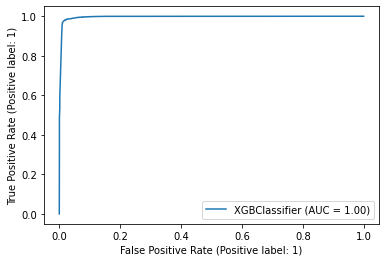

In [16]:
plot_roc_curve(xgb, X_teste, y_teste)

## XGBoost Balanceado

In [17]:
%%time

xgb = XGBClassifier(
    n_estimators=8,
    max_depth=8,
    subsample=1.0,
    #gpu_id='0',
    #tree_method='gpu_hist'

)

xgb.fit(X_comb, y_comb) 
y_xgb = xgb.predict(X_teste)

confusion_matrix(y_teste, y_xgb)

[12:18:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 3min 55s, sys: 645 ms, total: 3min 56s
Wall time: 1min 13s


array([[   2093,     342],
       [   3657, 1902694]])

In [18]:
 print(classification_report(y_teste, y_xgb, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.36      0.86      0.51      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.68      0.93      0.76   1908786
weighted avg       1.00      1.00      1.00   1908786



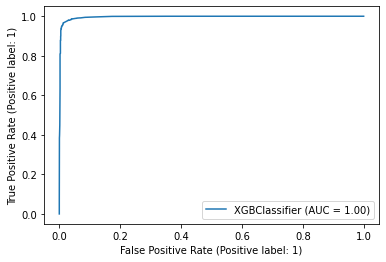

In [19]:
plot_roc_curve(xgb, X_teste, y_teste)
plt.show()